In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots
import colorcet as cc
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm

/tmp/ipykernel_739592/1353020367.py:9: DeprecationWarning: The module 'mceq_config' has been moved to 'MCEq.config'. Please update your `import mceq_config` to `import MCEq.config` accordingly.
  import mceq_config as config


In [2]:
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='SIBYLL2.3c',
    #primary cosmic ray flux model
    #support a tuple (primary model class (not instance!), arguments)
    primary_model=(pm.HillasGaisser2012, 'H3a'),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
    )

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
def numuparent_spetrumplot(save_folder,mceq_run):    
    #'''Plot numu spectrum for July 1 and January based on parent particle from MCEq.    Paper Fig. 3'''    
    
    # define angles
    max_zenith = np.cos(np.deg2rad(110.))
    min_zenith = np.cos(np.deg2rad(90.))
    angles_edges = np.arccos(np.linspace(min_zenith,max_zenith,6))*180./np.pi # edges theta
    angles = np.zeros(5)
    for i in range(len(angles)):
        angles[i] = np.mean([angles_edges[i],angles_edges[i+1]]) # calculates bin width for theta
    
    angles = np.round(angles,decimals=2)    
    mceq_run.set_density_model(('MSIS00_IC',('SouthPole','January')))    
    
    # calculate flux with mceq
    mag = 3 #Scales the flux by E^3 (makes graph less steep)
    doys = [0,182] #January and July
    result_total = []
    result_pr = []
    result_conv = []
    result_pi = []
    result_k = []
    result_mudecay = []    
    
    #shape(zenith,doy,energy)
    for sim_angle in angles:
        print('zenith:', sim_angle)
        mceq_run.set_theta_deg(sim_angle)
        result_total.append([])
        result_conv.append([])
        result_pr.append([])
        result_pi.append([])
        result_k.append([])
        result_mudecay.append([])        
        for d in doys:
            mceq_run.density_model.set_doy(d)
            mceq_run.density_model.theta_deg = np.deg2rad(sim_angle)
            mceq_run.density_model.calculate_density_spline()
            mceq_run._calculate_integration_path(int_grid=None, grid_var='X',force=True)
            mceq_run.solve()
            result_total[-1].append(mceq_run.get_solution('total_numu', mag)
                            + mceq_run.get_solution('total_antinumu', mag))
            result_pr[-1].append(mceq_run.get_solution('pr_numu', mag)
                            + mceq_run.get_solution('pr_antinumu', mag))
            result_conv[-1].append(mceq_run.get_solution('conv_numu', mag)
                            + mceq_run.get_solution('conv_antinumu', mag))
            result_pi[-1].append(mceq_run.get_solution('pi_numu', mag)
                            + mceq_run.get_solution('pi_antinumu', mag))
            result_k[-1].append(mceq_run.get_solution('k_numu', mag)
                            + mceq_run.get_solution('k_antinumu', mag))
            result_mudecay[-1].append(mceq_run.get_solution('mulr_numu', mag)
                            + mceq_run.get_solution('mulr_antinumu', mag) + mceq_run.get_solution('mu_h0_antinumu', mag) + mceq_run.get_solution('mu_h0_numu', mag))    
            e_center = (mceq_run.e_bins[:-1] + mceq_run.e_bins[1:]) / 2    

    A4_width_inches = 0.5*8.27  # Width of A4 paper in inches
    A4_height_inches = A4_width_inches * 0.75 # Height is one-third of width
    figsize = (A4_width_inches, A4_height_inches)    
    
    # Create subplots using GridSpec
    fig = plt.figure(figsize=figsize, dpi=500)
    fig.tight_layout(pad=0.4)
    plt.rcParams.update({'font.size': 10})
    plt.style.use('science')
    plt.style.use('tableau-colorblind10')
    plt.rcParams['text.usetex'] = False
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']    
    
    # Create a gridspec with 2 rows and 1 column, where the second row will be narrow
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=.1)  # 3:1 ratio between upper and lower plots    
    
    # Upper plot for the spectrum
    ax1 = fig.add_subplot(gs[0])
    # Lower plot for the fraction
    ax2 = fig.add_subplot(gs[1], sharex=ax1)    
    
    # Plot lines with labels (same as before)
    line_total_jan, = ax1.plot(e_center, np.mean(result_total, axis=0)[0], color='black', label=r'$\nu_{\mathrm{\mu}} + \bar{\nu}_{\mathrm{\mu}}$ (total)')
    line_total_jul, = ax1.plot(e_center, np.mean(result_total, axis=0)[1], color='black', ls='--')    
    line_k_jan, = ax1.plot(e_center, np.mean(result_k, axis=0)[0], label=r'$\nu_{\mathrm{\mu}} + \bar{\nu}_{\mathrm{\mu}}$ from $K$', color=colors[4])
    line_k_jul, = ax1.plot(e_center, np.mean(result_k, axis=0)[1], ls='--', color=colors[4])    
    line_pi_jan, = ax1.plot(e_center, np.mean(result_pi, axis=0)[0], label=r'$\nu_{\mathrm{\mu}} + \bar{\nu}_{\mathrm{\mu}}$ from $\pi$', color=colors[5])
    line_pi_jul, = ax1.plot(e_center, np.mean(result_pi, axis=0)[1], ls='--', color=colors[5])    
    line_mu_jan, = ax1.plot(e_center, np.mean(result_pr, axis=0)[0], label=r'$\nu_{\mathrm{\mu}} + \bar{\nu}_{\mathrm{\mu}}$ (prompt)', color=colors[8])
    line_mu_jul, = ax1.plot(e_center, np.mean(result_pr, axis=0)[1], ls='--', color=colors[8])    
    line_mu_jan, = ax1.plot(e_center, np.mean(result_mudecay, axis=0)[0], label=r'$\nu_{\mathrm{\mu}} + \bar{\nu}_{\mathrm{\mu}}$ from $\mu$', color=colors[2])
    line_mu_jul, = ax1.plot(e_center, np.mean(result_mudecay, axis=0)[1], ls='--', color=colors[2])    
    
    # Axes labels and text (same as before)
    #ax1.set_xlabel('$E$/GeV')
    ax1.set_ylabel(r'$E^{3}$ $\Phi_{\nu_\mu + \bar{\nu}_\mu}$ /' + '\n' + r'GeV$^{2}$ cm$^{-2}$s$^{-1}$sr$^{-1}$')
    ax1.text(0.35, 0.05, '$90^{\circ} \leq \Theta \leq 110^{\circ}$', verticalalignment='bottom', horizontalalignment='right', transform=ax1.transAxes, color=colors[3])
    plt.setp(ax1.get_xticklabels(), visible=False)    
    
    # Log scales and limits (same as before)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(50., 1e6)
    ax1.set_ylim(2e-4, 1.1e-1)
    ax1.minorticks_on()
    ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
    ax1.tick_params(axis='y', which='both', direction='in', left=True, right=True)    
    
    # Dummy lines for January and July to show in legend in color[3]
    line_jan = plt.Line2D([0], [0], color=colors[3],  label='January ')
    line_jul = plt.Line2D([0], [0], color=colors[3],  linestyle='--', label='July ')    
    
    # Legend for line styles (solid and dashed), placed inside the plot
    line_style_legend = ax1.legend(handles=[line_jan, line_jul], loc='upper right', frameon=False)    # Legend for colors, placed above the plot
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 1.15), ncol=2)    # Plot fraction of each parent to the total flux in the lower plot
    fraction_k = np.mean(result_k, axis=0) / np.mean(result_total, axis=0)
    fraction_pi = np.mean(result_pi, axis=0) / np.mean(result_total, axis=0)
    fraction_mu = np.mean(result_pr, axis=0) / np.mean(result_total, axis=0)
    fraction_mudecay = np.mean(result_mudecay, axis=0) / np.mean(result_total, axis=0)   

    #Plot the data 
    ax2.plot(e_center, fraction_k[0], label=r'Fraction from $K$', color=colors[4])
    ax2.plot(e_center, fraction_k[1], ls='--', color=colors[4])    
    ax2.plot(e_center, fraction_pi[0], label=r'Fraction from $\pi$', color=colors[5])
    ax2.plot(e_center, fraction_pi[1], ls='--', color=colors[5])    
    ax2.plot(e_center, fraction_mu[0], label=r'Fraction from $\mu$', color=colors[8])
    ax2.plot(e_center, fraction_mu[1], ls='--', color=colors[8])    
    ax2.plot(e_center, fraction_mudecay[0], label=r'Fraction from $\mu$ decay', color=colors[2])
    ax2.plot(e_center, fraction_mudecay[1], ls='--', color=colors[2])    
    ax2.set_xlabel('$E$/GeV')
    ax2.set_ylabel('Fraction ')    
    # Set limits for the lower plot
    ax2.set_xscale('log')
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_xlim(50., 1e6)    
    # Save the figure
    plt.savefig(save_folder, bbox_inches='tight')
    plt.show()

MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
zenith: 91.96
MSIS00IceCubeCentered::set_theta(): latitude = -86.07 for zenith angle = 91.96
MSIS00IceCubeCentered::set_theta(): theta = 91.96 below horizon. using theta = 88.04
zenith: 95.89
MSIS00IceCubeCentered::set_theta(): latitude = -78.22 for zenith angle = 95.89
MSIS00IceCubeCentered::set_theta(): theta = 95.89 below horizon. using theta = 84.11
zenith: 99.85
MSIS00IceCubeCentered::set_theta(): latitude = -70.30 for zenith angle = 99.85
MSIS00IceCubeCentered::set_theta(): theta = 99.85 below horizon. using theta = 80.15
zenith: 103.86
MSIS00IceCubeCentered::set_theta(): latitude = -62.28 for zenith angle = 103.86
MSIS00IceCubeCentered::set_theta(): theta = 103.86 below horizon. using theta = 76.14
zenith: 107.94
MSIS00IceCubeCentered::set_theta(): latitude = -54.12 for zenith angle = 107.94
MSIS00IceCubeCenter

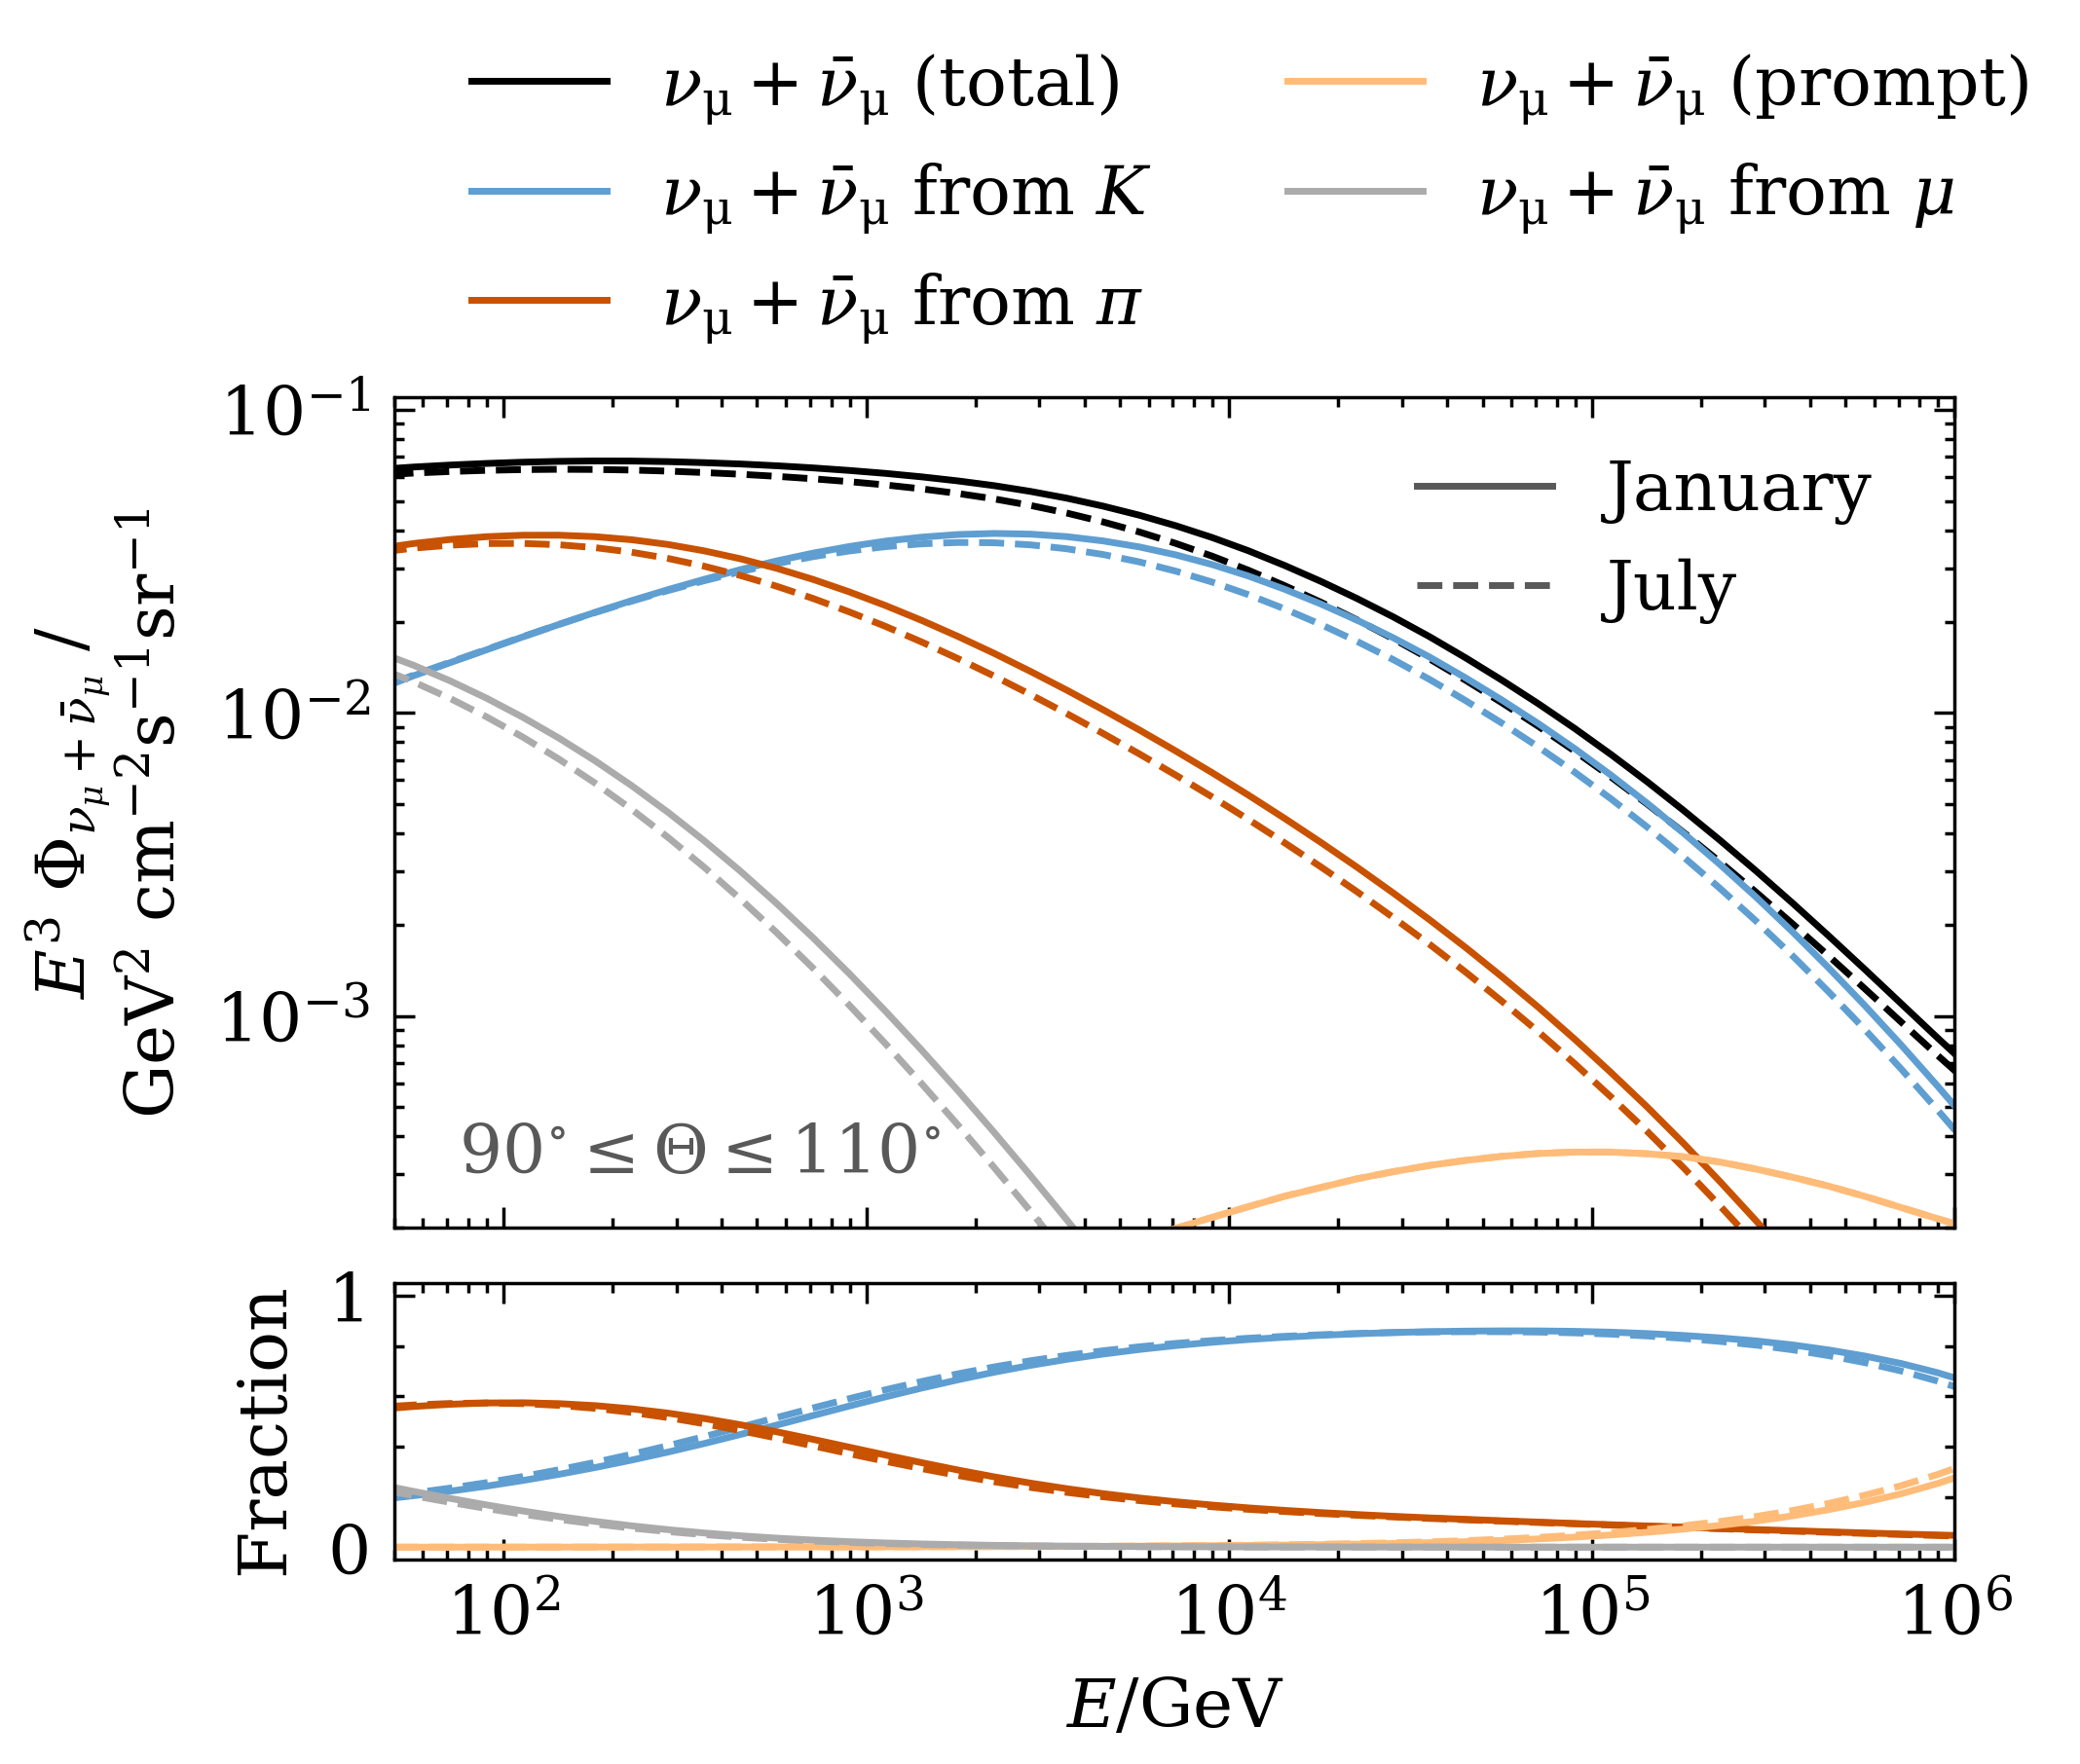

In [4]:
#Call and run the function. 
path = r"/net/apphome/home/nbenton/PROJECT/"

numuparent_spetrumplot(path ,mceq_run)